# Estimating and maximizing information in Deep Representations

In this notebook, we showcase how `torch_mist` can be used for training neural representations, and quantitative/qualitative evaluation purposes.
This example focuses on measuring an optimizing how much information a deep `resnet18` representation contains about the position of eyes, nose and mouth in the CelebA pictures.

By estimating mutual information with a simple generative estimator, we demonstrate that a `resnet18` architecture pretrained on ImageNet contains more information than a randomly initialized architecture, and that is possible to increase the amount of information about the landmarks location by fine-tuning the encoder.
The `scripts/celeba_landmaks.py` script contains details on helper classes and training procedure.


## Loading the CelebA dataset

The `CelebALandmarks` dataset is an extension of the `torchvision.datasets.CelebA` dataset, modified to return a dictionary containing images and landmarks.

We first instantiate and visualize the training data:


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from scripts.examples.celeba_landmarks import CelebALandmarks, LANDMARKS, REPRESENTATIONS

# CelebA download location. 
DATA_DIR = '/data'

# Load the CelebA Dataset
dataset = CelebALandmarks(DATA_DIR)

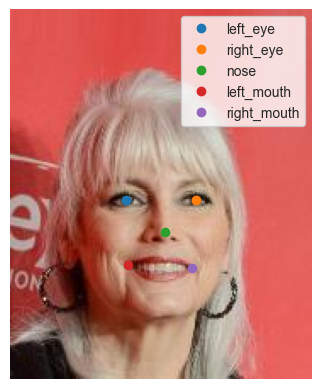

In [32]:
# Consider a datapoint
idx = 898
data = dataset[idx]

# We plot image and the corresponding landmarks
for name, value in data.items():
    if name == 'image':
        plt.imshow(value.permute(1,2,0))
    else:
        plt.plot(value[0],value[1], 'o', label=name)

plt.legend()
plt.axis('off');

In [36]:
from torch.utils.data import DataLoader, Subset

num_workers = 8

# Lastly, we define a two dataloaders for training and testing purposes 
trainloader = DataLoader(
    dataset,
    batch_size=128,
    num_workers=num_workers
)

# To speed up the evaluation process we evaluate mutual information only for the first 1000 pictures
testloader = DataLoader(
    Subset(dataset, range(1000)),
    batch_size=32,
    num_workers=num_workers
)

## Multi-mutual Information Estimation

We use the `torch_mist` package to define 5x3 mutual information estimator (one for each landmark and for each encoder) that are jointly trained on the data using the `MultiMIEstimator` class. Each single estimator consists of an instance of the Difference of Entropies `DoE` generative estimator.

In [3]:
import torch
from torch_mist.utils.freeze import freeze
from scripts.examples.celeba_landmarks import ResNet18Encoder

# We first define three encoders that will be used to create 3 pictures representations
encoders = {
    # A frozen randomly initialized resnet18 encoder
    "random_init": freeze(ResNet18Encoder(weights=None)),
    # A frozen pre-trained restnet18 encoder
    "pretrained": freeze(ResNet18Encoder(weights="DEFAULT")),
    # And pretrained resnet18 encoder that can be optimized over time
    "finetuned": ResNet18Encoder(weights="DEFAULT"),
}

In [39]:
from torch_mist.estimators import DoE, MultiMIEstimator
from torch_mist.distributions import (
    transformed_normal,
    conditional_transformed_normal,
)
from scripts.examples.celeba_landmarks import HIDDEN_DIMS, Z_DIM

# We model one marginal distribution q_\phi(landmark) for each landmark position using spline autoregressive flows
q_Y = {
    landmark: transformed_normal(
        input_dim=2,
        hidden_dims=HIDDEN_DIMS,
        transform_name="spline_autoregressive",
        n_transforms=2,
    )
    for landmark in LANDMARKS
}

estimators = {}
# We define 5x3 estimators (one for each feature and each representation) using doe (Difference of Entropies)
for representation in REPRESENTATIONS:
    for landmark in LANDMARKS:
        # Define a variational conditional distribution q_\theta(landmark|representation)
        # Using spline autoregressive flows
        q_Y_given_X = conditional_transformed_normal(
            input_dim=2,
            context_dim=Z_DIM,
            transform_name="conditional_spline_autoregressive",
            hidden_dims=HIDDEN_DIMS,
            n_transforms=2,
        )
        
        # Each estimator relies on the estimation of the difference between H(y|x) and H(y).
        # Both entropies are estimated using variational distribution transformed using spline_autoregressive flows.
        # Note that x refers to the image representations [512], while y to the coordinates of each landmark [2].
        estimators[(representation, landmark)] = DoE(
            q_Y_given_X=q_Y_given_X, q_Y=q_Y[landmark]
        )
        
# We put all the estimators together using the MultiMIEstimator class
multi_estimator = MultiMIEstimator(estimators)

In [5]:
from torch_mist.estimators import TransformedMIEstimator

# Since we are interested in estimating the mutual information between the resnet representations
# and not the original images, we use the TransformedMIEstimator class to apply the 3 encoders to each image.
mi_estimator = TransformedMIEstimator(
    # This can be done by specifying a dictionary of tuples "(name_from, name_to) : transform"
    transforms_rename={
        ("image", representation_name): encoder
        for representation_name, encoder in encoders.items()
    },
    # and the estimator to use after the transformations are applied.
    base_estimator=multi_estimator,
)

## Training the estimators

The estimators can be easily trained using the `train_mi_estimator` utility. 
In this example, we load an estimator trained and logged using Weights & Biases. 
Use `pip install wandb` to install the required dependencies or use `train=True` to train the model in this notebook. 

The training process requires a few hours on a single GPU.

In [6]:
from torch_mist.utils.train import train_mi_estimator

train = False
device = 'cuda'

if train:
    log = train_mi_estimator(
        estimator=mi_estimator,
        train_loader=trainloader,
        max_epochs=20,
        verbose=True,
        device=device,
    )   
else:
    import wandb
    import os
    
    # Download the artifact corresponding to the model from wandb
    api = wandb.Api()
    artifact = api.artifact("mfederici/torch_mist/celeba_landmarks:latest")
    datadir = artifact.download()
    
    # Load the trained mutual information estimator
    trained_mi_estimator = torch.load(
        os.path.join(datadir, 'trained.pyt'), 
        map_location=torch.device('cpu')
    )
    # Copy the state dictionary (trained_mi_estimator and mi_estimator are the same)
    mi_estimator.load_state_dict(trained_mi_estimator.state_dict())

    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Downloading large artifact celeba_landmarks:latest, 152.99MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


## Results and visualizations
Using the trained estimators, we can estimate the mutual information between all pairs of representations and landmarks. 

In [37]:
from torch_mist.utils import evaluate_mi

# Evaluate mutual information (May require a few minutes on cpu)
mutual_information = evaluate_mi(
    mi_estimator,
    dataloader=testloader
)
mutual_information


{'I(random_init;left_eye)': 0.21431639278307557,
 'I(random_init;right_eye)': 0.1918627768754959,
 'I(random_init;nose)': 0.6175462226383388,
 'I(random_init;left_mouth)': 0.1474936273880303,
 'I(random_init;right_mouth)': 0.2960611809976399,
 'I(pretrained;left_eye)': 0.5163506157696247,
 'I(pretrained;right_eye)': 0.5674194898456335,
 'I(pretrained;nose)': 1.208534337580204,
 'I(pretrained;left_mouth)': 0.5828070770949125,
 'I(pretrained;right_mouth)': 0.6729186745360494,
 'I(finetuned;left_eye)': 3.396965302526951,
 'I(finetuned;right_eye)': 3.76092042773962,
 'I(finetuned;nose)': 4.4084951132535934,
 'I(finetuned;left_mouth)': 3.0865019112825394,
 'I(finetuned;right_mouth)': 3.395381636917591}

And plot the values on a histogramm.

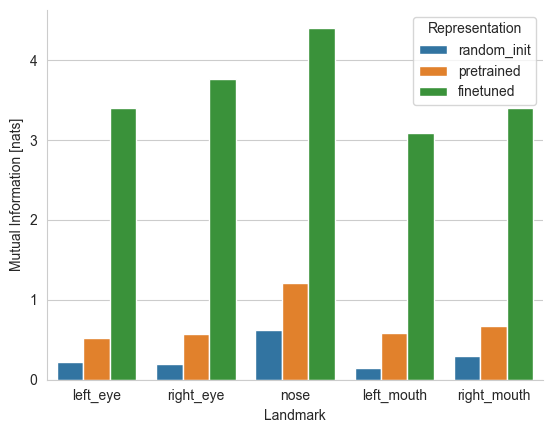

In [38]:
import pandas as pd

results = []

# For simplicity, we convert the list of the mutual information into a pandas dataframe
for name, value in mutual_information.items():
    name = name.replace('I(', '').replace(')','')
    result = {
        'Representation': name.split(';')[0],
        'Landmark': name.split(';')[1],
        'Mutual Information [nats]': value
    }
    results.append(result)

results = pd.DataFrame(results)


sns.barplot(
    results, 
    x='Landmark', hue='Representation', y='Mutual Information [nats]', 
    hue_order=REPRESENTATIONS,
    order=LANDMARKS
)
sns.despine()

Since the `DoE` estimator explicitly defines variational models $q(\text{landmark})$ and $q(\text{landmark}|\text{representation})$, we can visualize the marginal landmark distribution and the location conditioned on the various resnet representation.

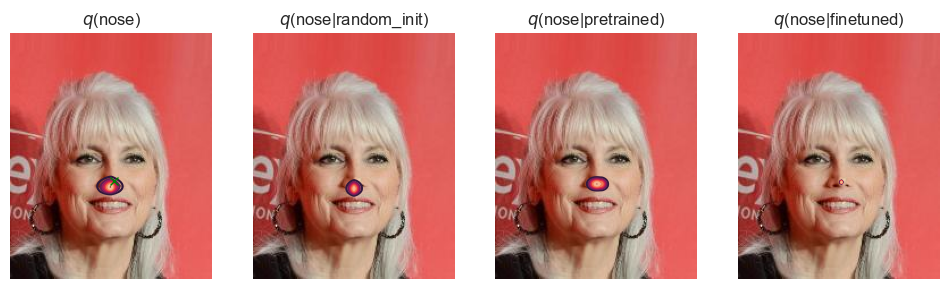

In [34]:
import numpy as np

# Consider an instance
idx = 898
# And the nose location as the landmark
landmark_name = 'nose'
landmark_pos = data[landmark_name].data.numpy()[0]

# Encode all the representations
data = {key: value.unsqueeze(0) for key, value in dataset[idx].items()}
img = data['image']
encoded_data = mi_estimator.transform(**data)

# Prepare the axis
f, ax = plt.subplots(
    1,len(REPRESENTATIONS)+1, 
    figsize=(len(REPRESENTATIONS)*4,4)
)

# Make a uniform grid of XY coordinates
x_axis = np.arange(img.shape[2])+1
y_axis = np.arange(img.shape[3])+1
Y, X = np.meshgrid(x_axis, y_axis)
XY = torch.cat([
    torch.FloatTensor(X).unsqueeze(-1),
    torch.FloatTensor(Y).unsqueeze(-1),
],-1)

# Consider the distribution q(nose) and evaluate the probability on the whole grid
marginal = mi_estimator.base_estimator.estimators[f'random_init;{landmark_name}'].q_Y
q_y = marginal.log_prob(XY).data.exp()

# Plot the image
ax[0].imshow(data['image'][0].permute(1,2,0))
# and the marginal probability corresponding to the nose location
ax[0].contour(X, Y, q_y)
# together with the actual nose location
ax[0].plot(landmark_pos[0], landmark_pos[1], 'xg')
ax[0].set_title(f'$q$({landmark_name})')
ax[0].axis('off')

# Plot the same for each of the q(nose|representation) (one for each representation)
for i, representation in enumerate(REPRESENTATIONS):
    # Consider q(nose|representation) and compute the probability on the whole grid
    conditional = mi_estimator.base_estimator.estimators[f'{representation};{landmark_name}'].q_Y_given_X
    q_y_given_x = conditional.condition(encoded_data[representation].unsqueeze(0)).log_prob(XY).data.exp()
    
    # Plot the image and the corresponding probability contour and ground truth location
    ax[i+1].imshow(data['image'][0].permute(1,2,0))
    ax[i+1].contour(X,Y,q_y_given_x)
    ax[i+1].set_title(f'$q$({landmark_name}|{representation})')
    ax[i+1].axis('off')

Clearly the randomly initialized network contains less infomation regarding the location of the landmarks than a network pretrained on image classification.
As expected, fine-tuning the representation to maximize the landmark-position-predictive information yields the most informative representations. This can also be seen by comparing the sharpness of the posterior distribution.